**Kaggle "Titanic: Machine Learning from Disaster".**

In [4]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv",index_col='PassengerId')

In [6]:
df=df.drop(['Ticket','Cabin','Embarked','Name'],axis=1)

In [7]:
holdout = df.sample(100) # рандомная отложенная часть
df = df.loc[~df.index.isin(holdout.index)] #наш датасет без отложенной части

In [8]:
#целевое событие
y = df.Survived

In [9]:
#датасет без целевого события
df= df.drop(['Survived'],axis=1)

In [10]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,3,male,22.0,1,0,7.2500
2,1,female,38.0,1,0,71.2833
3,3,female,26.0,0,0,7.9250
4,1,female,35.0,1,0,53.1000
5,3,male,35.0,0,0,8.0500


**ЗАДАНИЕ**

1) Разбейте данные на train и test (пропорция 80/20, укажите в параметрах random_state = 17 и stratify = y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, train_size=0.8, random_state=17, stratify=y)

In [12]:
y_test.value_counts()

0    97
1    62
Name: Survived, dtype: int64

2) Примените к обеим частям выборки пайплайн vec(задан ниже) 

In [13]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
 
def get_categ_col(df):
    return df[['Sex','Pclass']]
 
def get_num_cols(df):
    return df[['Age', 'Fare', 'SibSp', 'Parch']]
 
vec = make_union(*[
   make_pipeline(FunctionTransformer(get_categ_col, validate=False),  OneHotEncoder(sparse=False)),
   make_pipeline(FunctionTransformer(get_num_cols, validate=False), SimpleImputer(strategy='median'), StandardScaler()),
])

In [14]:
vec.fit(X_train)
 
X_train_transformed = pd.DataFrame(vec.transform(X_train))
X_test_transformed = pd.DataFrame(vec.transform(X_test))

In [15]:
X_train_transformed

,0,1,2,3,4,5,6,7,8
0,0.0,1.0,0.0,0.0,1.0,-0.626216,-0.502150,-0.482365,-0.483733
1,0.0,1.0,1.0,0.0,0.0,0.519335,-0.093357,-0.482365,-0.483733
2,1.0,0.0,1.0,0.0,0.0,0.901185,2.315710,-0.482365,-0.483733
3,0.0,1.0,0.0,0.0,1.0,-0.778957,-0.508272,-0.482365,-0.483733
4,1.0,0.0,1.0,0.0,0.0,-1.084437,4.026295,-0.482365,0.828366
...,...,...,...,...,...,...,...,...,...
627,0.0,1.0,0.0,0.0,1.0,-0.091626,-0.160979,1.471830,-0.483733
628,0.0,1.0,0.0,1.0,0.0,-0.397106,-0.389168,-0.482365,-0.483733
629,0.0,1.0,0.0,1.0,0.0,1.283035,-0.099758,-0.482365,-0.483733
630,0.0,1.0,1.0,0.0,0.0,3.115917,0.902049,0.494733,0.828366


3) С помощью GridSearchCV обучите модель LogisticRegression: сбалансируйте классы, переберите значения параметра С [0.01, 0.05, 0.1, 0.5, 1, 5, 10], задайте 3 фолда на кроссвалидации

Посчитайте средний roc_auc на тестовых фолдах (возьмите 3 значения из cv_results).

In [16]:
cv = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'C' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        'class_weight': ['balanced']
    },
    cv=3
).fit(X_train_transformed, y_train)

In [17]:
np.mean(cv.cv_results_['mean_test_score'])

0.7768288357997228

4) Посчитайте roc_auc для выборки holdout.

In [18]:
from sklearn.metrics import roc_auc_score
 
holdout_X = holdout.drop(axis=1, labels=['Survived'])
holdout_y = holdout[['Survived']]
holdout_X_transformed = pd.DataFrame(vec.transform(holdout_X))
 
roc_auc_score(holdout_y, cv.best_estimator_.predict(holdout_X_transformed))

0.8419117647058824

5) Посчитайте долю влияния фичи Pclass на итоговое предсказание.

In [19]:
holdout_X

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
122,3,male,NaN,0,0,8.0500
774,3,male,NaN,0,0,7.2250
849,2,male,28.0,0,1,33.0000
364,3,male,35.0,0,0,7.0500
433,2,female,42.0,1,0,26.0000
...,...,...,...,...,...,...
87,3,male,16.0,1,3,34.3750
788,3,male,8.0,4,1,29.1250
626,1,male,61.0,0,0,32.3208


In [20]:
holdout_X_transformed.columns = cols = ['is_female', 'is_male', 'pclass_1', 'pclass_2', 'pclass_3', 'age', 'sibsp', 'parch', 'fare']
holdout_X_transformed

,is_female,is_male,pclass_1,pclass_2,pclass_3,age,sibsp,parch,fare
0,0.0,1.0,0.0,0.0,1.0,-0.091626,-0.499367,-0.482365,-0.483733
1,0.0,1.0,0.0,0.0,1.0,-0.091626,-0.517734,-0.482365,-0.483733
2,0.0,1.0,0.0,1.0,0.0,-0.091626,0.056079,-0.482365,0.828366
3,0.0,1.0,0.0,0.0,1.0,0.442965,-0.521630,-0.482365,-0.483733
4,1.0,0.0,0.0,1.0,0.0,0.977555,-0.099758,0.494733,-0.483733
...,...,...,...,...,...,...,...,...,...
95,0.0,1.0,0.0,0.0,1.0,-1.008067,0.086690,0.494733,3.452564
96,0.0,1.0,0.0,0.0,1.0,-1.619027,-0.030188,3.426025,0.828366
97,0.0,1.0,1.0,0.0,0.0,2.428587,0.040959,-0.482365,-0.483733
98,1.0,0.0,1.0,0.0,0.0,1.053925,4.026295,-0.482365,0.828366


In [21]:
contribution = pd.DataFrame((np.exp(cv.best_estimator_.coef_) / np.exp(cv.best_estimator_.coef_).sum()), columns=holdout_X_transformed.columns)
contribution

,is_female,is_male,pclass_1,pclass_2,pclass_3,age,sibsp,parch,fare
0,0.314994,0.024182,0.246598,0.083781,0.032163,0.055592,0.095235,0.065133,0.082322


In [22]:
contribution[['pclass_1', 'pclass_2', 'pclass_3']].iloc[0].sum()

0.3625419706363904

6) Теперь попробуйте применить к тем же данным дерево решений. 
Переберите значения для 5 разных параметров дерева решений (глубина, число листьев и т.д.) с помощью RandomizedSearch(n_iter = 100). Посчитайте roc_auc

In [23]:
X_train_transformed.columns = cols
X_train_transformed

,is_female,is_male,pclass_1,pclass_2,pclass_3,age,sibsp,parch,fare
0,0.0,1.0,0.0,0.0,1.0,-0.626216,-0.502150,-0.482365,-0.483733
1,0.0,1.0,1.0,0.0,0.0,0.519335,-0.093357,-0.482365,-0.483733
2,1.0,0.0,1.0,0.0,0.0,0.901185,2.315710,-0.482365,-0.483733
3,0.0,1.0,0.0,0.0,1.0,-0.778957,-0.508272,-0.482365,-0.483733
4,1.0,0.0,1.0,0.0,0.0,-1.084437,4.026295,-0.482365,0.828366
...,...,...,...,...,...,...,...,...,...
627,0.0,1.0,0.0,0.0,1.0,-0.091626,-0.160979,1.471830,-0.483733
628,0.0,1.0,0.0,1.0,0.0,-0.397106,-0.389168,-0.482365,-0.483733
629,0.0,1.0,0.0,1.0,0.0,1.283035,-0.099758,-0.482365,-0.483733
630,0.0,1.0,1.0,0.0,0.0,3.115917,0.902049,0.494733,0.828366


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
 
tree_params = {
    'max_depth': range(2, 6),
    'min_samples_leaf': range(2, 5),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': ['auto', 'sqrt', 'log2']
}
 
locally_best_tree = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    tree_params,
    n_iter=100,
).fit(X_train_transformed, y_train)

In [25]:
np.mean(locally_best_tree.cv_results_['mean_test_score'])

0.7895469316335456

7) Возьмите лучшее дерево из п.6 и визуализируйте его с помощью graphviz 

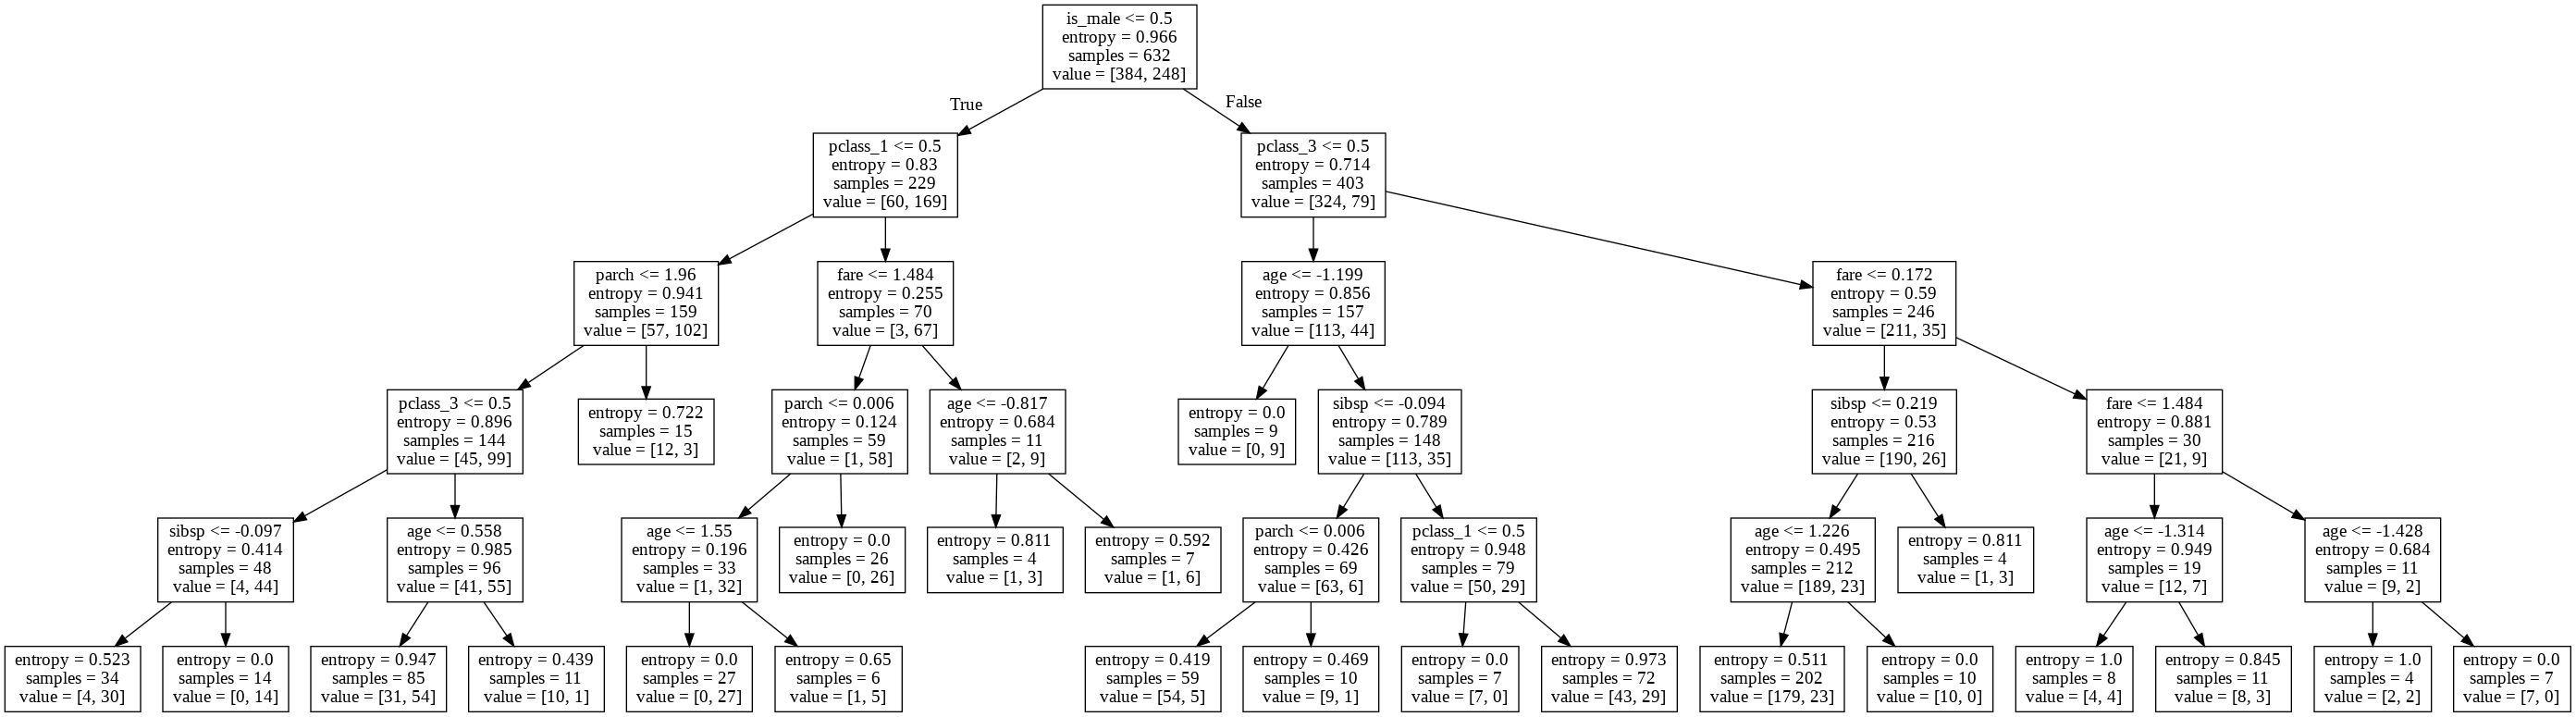

In [26]:
import sklearn
from graphviz import Source
from IPython.display import Image
 
best = locally_best_tree.best_estimator_
 
graph = Source(sklearn.tree.export_graphviz(locally_best_tree.best_estimator_, out_file=None, feature_names=X_train_transformed.columns.values))
png_bytes = graph.pipe(format='png')
 
Image(png_bytes)

8) Запустите в цикле обучение дерева решений для X_train с разными значениями max_depth от 1 до 10. 
Нарисуйте график как меняется roc auc в зависимости от max_depth для выборок X_train и X_test, сравните насколько графики похожи.

In [27]:
X_test_transformed.columns = cols
X_test_transformed

,is_female,is_male,pclass_1,pclass_2,pclass_3,age,sibsp,parch,fare
0,1.0,0.0,0.0,0.0,1.0,0.061114,-0.140943,0.494733,0.828366
1,0.0,1.0,0.0,0.0,1.0,1.130295,-0.499367,-0.482365,-0.483733
2,0.0,1.0,1.0,0.0,0.0,0.442965,10.727086,-0.482365,-0.483733
3,0.0,1.0,1.0,0.0,0.0,1.206665,1.179773,0.494733,-0.483733
4,1.0,0.0,0.0,0.0,1.0,-0.091626,-0.320155,0.494733,-0.483733
...,...,...,...,...,...,...,...,...,...
154,0.0,1.0,0.0,0.0,1.0,-0.549846,-0.470426,-0.482365,-0.483733
155,1.0,0.0,0.0,1.0,0.0,0.442965,-0.211069,-0.482365,-0.483733
156,0.0,1.0,0.0,0.0,1.0,-0.015256,-0.502800,-0.482365,-0.483733
157,1.0,0.0,0.0,1.0,0.0,-0.855327,-0.389168,-0.482365,2.140465


In [28]:
max_depths = range(1, 11)
rocs_train = []
rocs_test = []
 
for i in max_depths:
    tree_ = DecisionTreeClassifier(max_depth=i).fit(X_train_transformed, y_train)
    prediction_train = tree_.predict(X_train_transformed)
    rocs_train.append(roc_auc_score(y_train, prediction_train))
    prediction_test = tree_.predict(X_test_transformed)
    rocs_test.append(roc_auc_score(y_test, prediction_test))

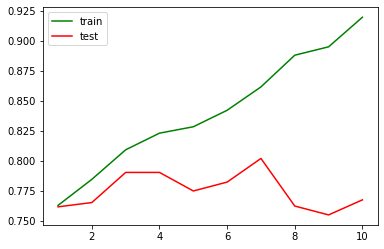

In [29]:
plt.plot(max_depths, rocs_train, color='green', label='train')
plt.plot(max_depths, rocs_test, color='red', label='test')
plt.legend()

Графики значительно отличаются друг от друга